In [20]:
import os
import cv2
import numpy as np
import face_recognition
from gender_detection import f_my_gender
from emotion_detection import f_emotion_detection
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
from PIL import Image
from tensorflow.keras.utils import plot_model
import warnings
from tqdm.notebook import tqdm
from keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline




## Load the dataset

In [21]:
# Set the directory where the images are located
BASE_DIR = '/Users/khalifa/Desktop/Face_info-master/UTKFace-All-Gneder'

# Initialize lists to store gender labels and image paths
gender_labels = []
image_paths = []

# Get a list of all image filenames in the directory and shuffle them
image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

# Loop through each image filename
for image in tqdm(image_filenames):
    # Create the full path of the image
    image_path = os.path.join(BASE_DIR, image)
    
    # Split the filename by removing the file extension and then separate parts by underscores
    img_components = image.split('.')[0].split('_')

    # Check if there are enough parts after splitting the filename
    if len(img_components) >= 2:
        # Extract the gender label from the filename components
        gender_label = int(img_components[1])

        # Append the gender label and image path to the respective lists
        gender_labels.append(gender_label)
        image_paths.append(image_path)
    else:
        # Print a message if there's an issue with a filename
        print(f"Issue with filename: {image}")


100%|██████████| 23708/23708 [00:00<00:00, 919127.44it/s]


In [22]:
# Print the number of gender labels and image paths collected
print(f'Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')


Number of gender_labels: 23708, Number of image_paths: 23708


In [23]:
# Mapping of gender labels to gender categories
gender_mapping = {
    1: 'Female',
    0: 'Male'
}


In [24]:
# Creating a DataFrame with image paths and gender labels
df = pd.DataFrame()
df['image_path'], df['gender'] = image_paths, gender_labels
df.head(5)


,image_path,gender
0,/Users/khalifa/Desktop/Face_info-master/UTKFac...,0
1,/Users/khalifa/Desktop/Face_info-master/UTKFac...,0
2,/Users/khalifa/Desktop/Face_info-master/UTKFac...,1
3,/Users/khalifa/Desktop/Face_info-master/UTKFac...,1
4,/Users/khalifa/Desktop/Face_info-master/UTKFac...,0


## Exploratory Data Anlysis

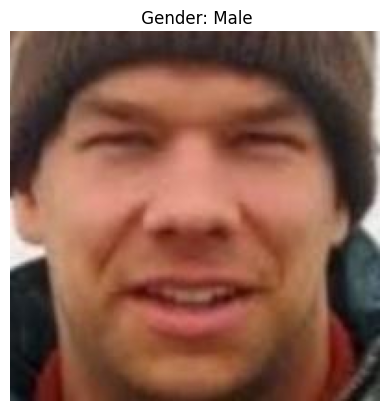

In [25]:
# Randomly select an index within the image paths list
rand_index = random.randint(0, len(image_paths))

# Retrieve the gender label and image path using the randomly selected index
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])

# Plot the image with its associated gender label
plt.title(f' Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)


<Axes: xlabel='gender', ylabel='Density'>

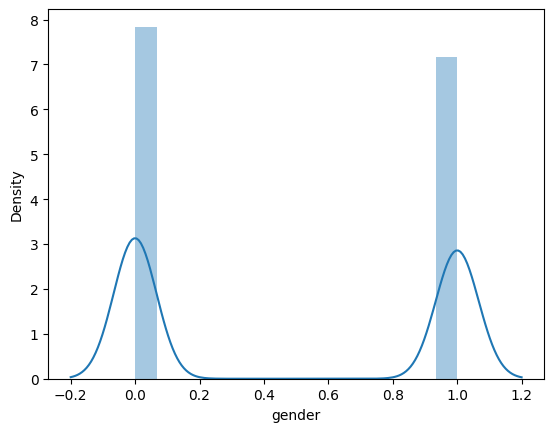

In [26]:
# gender distribution
sns.distplot(df['gender'])



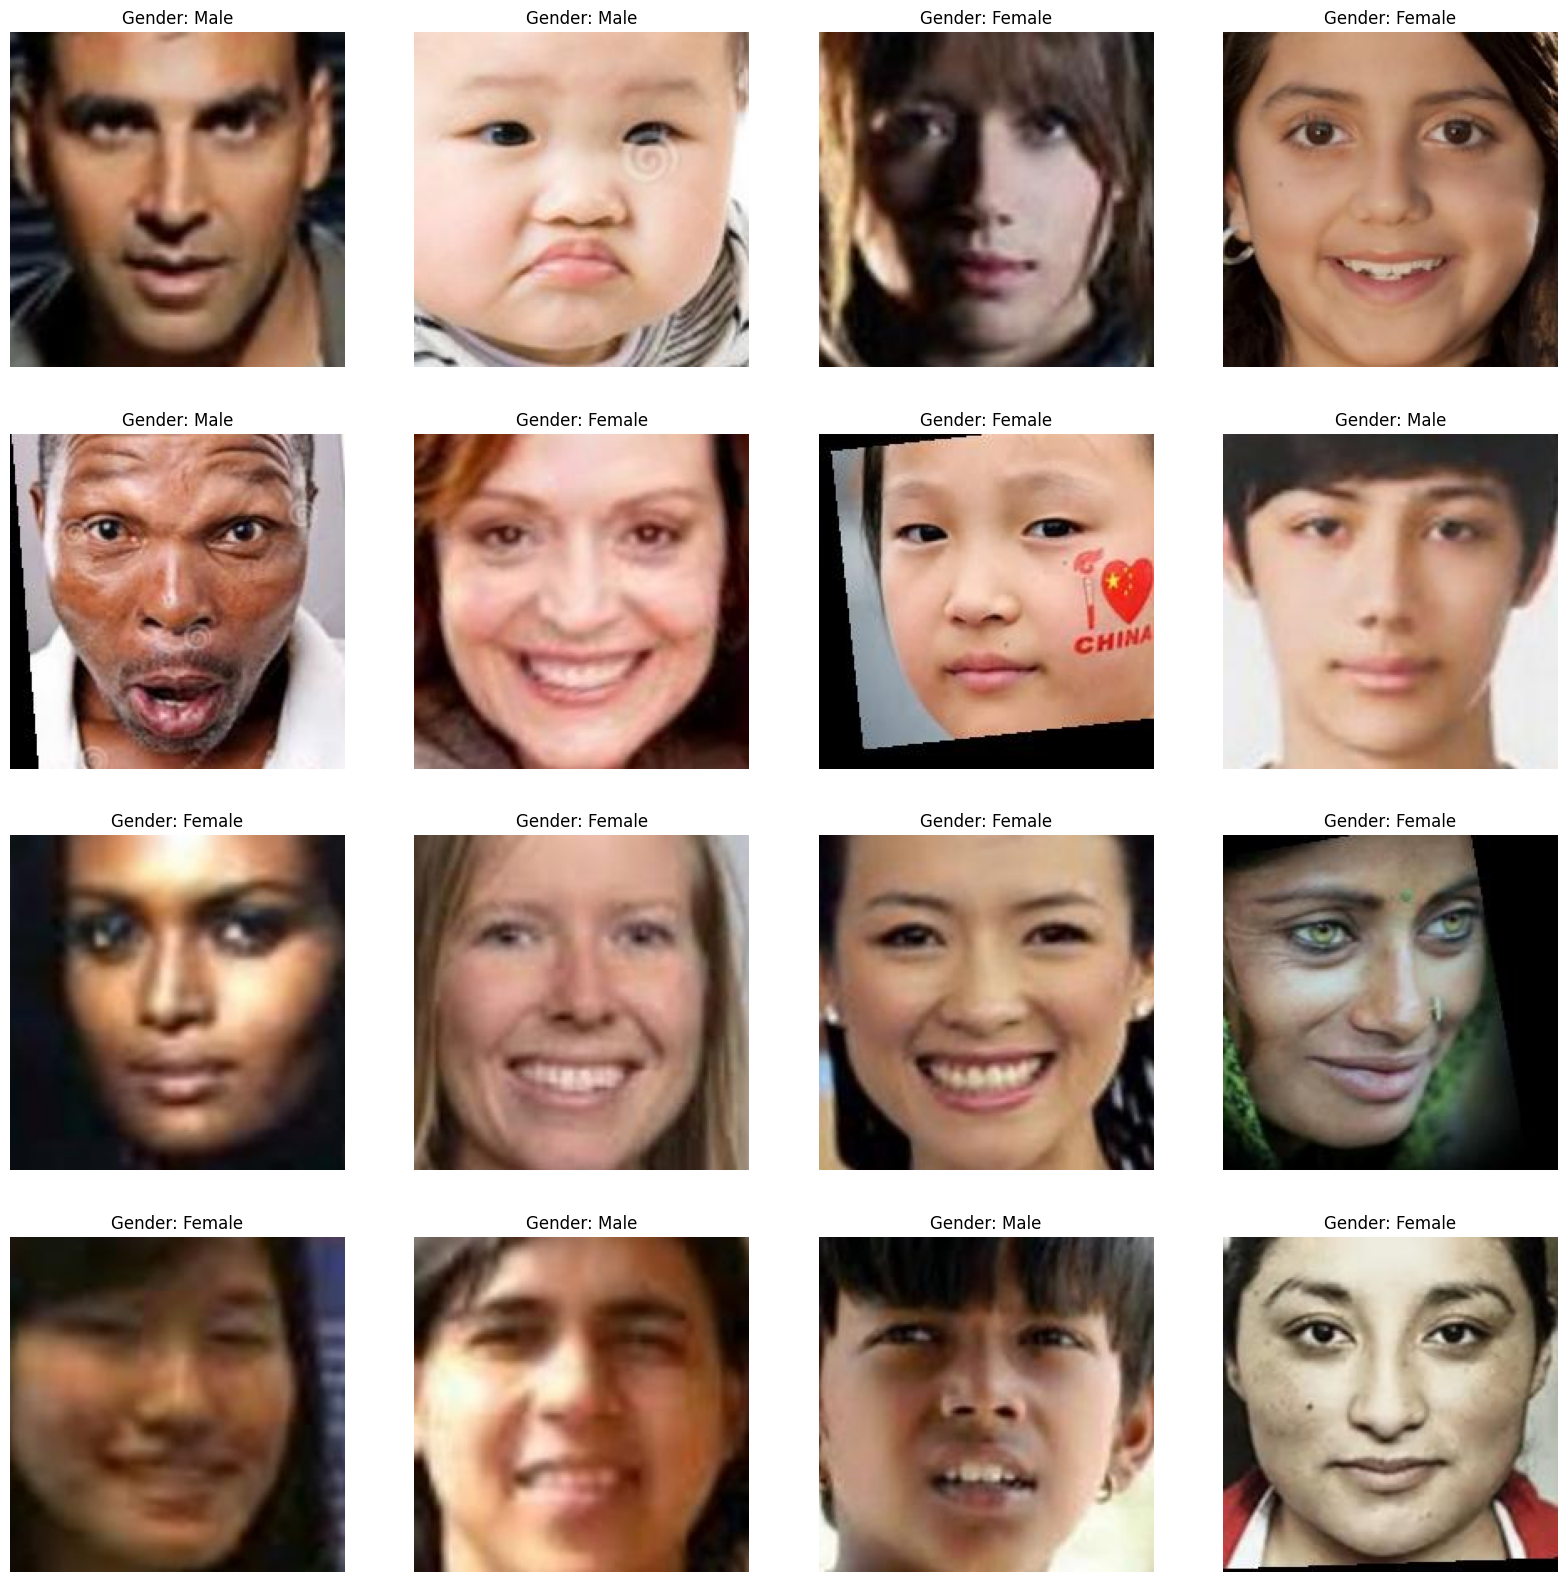

In [27]:
# Plot a grid of images and their corresponding genders
plt.figure(figsize=(20, 20))

# Select a subset of samples from the DataFrame and iterate through them
samples = df.iloc[0:16]
for index, (sample, gender) in enumerate(zip(samples['image_path'], samples['gender']), 1):
    plt.subplot(4, 4, index)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Gender: {gender_mapping[gender]}')
    plt.imshow(img)


## Feature Extraction

In [28]:
from PIL import Image
import numpy as np
from tqdm import tqdm
from keras.preprocessing.image import load_img

def extract_image_features(images):
    features = []

    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')  # load_img with color_mode='grayscale'
        img = img.resize((128, 128), Image.LANCZOS)  # Using LANCZOS resampling filter
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features



In [29]:
# Extracting features from images
X = extract_image_features(df['image_path'])


100%|██████████| 23708/23708 [00:17<00:00, 1384.45it/s]


In [30]:
# Displaying the shape of the extracted features
X.shape


(23708, 128, 128, 1)

In [31]:
# Defining the input shape for the model
input_shape = (128, 128, 1)


In [32]:
# Normalizing the image data
X = X / 255.0


In [33]:
# Converting gender labels to NumPy array
y_gender = np.array(df['gender'])


In [34]:
# Converting gender labels to NumPy array
y_gender = np.array(df['gender'])

# Define the input shape
inputs = Input((input_shape))

# Convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

# Flatten layer
flatten = Flatten()(max_4)

# Fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)

# Dropout layer
dropout_1 = Dropout(0.3)(dense_1)

# Output layer for gender prediction
output_1 = Dense(1, activation='softmax', name='gender_out')(dropout_1)

# Create and compile the model
model = Model(inputs=[inputs], outputs=[output_1])
model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])


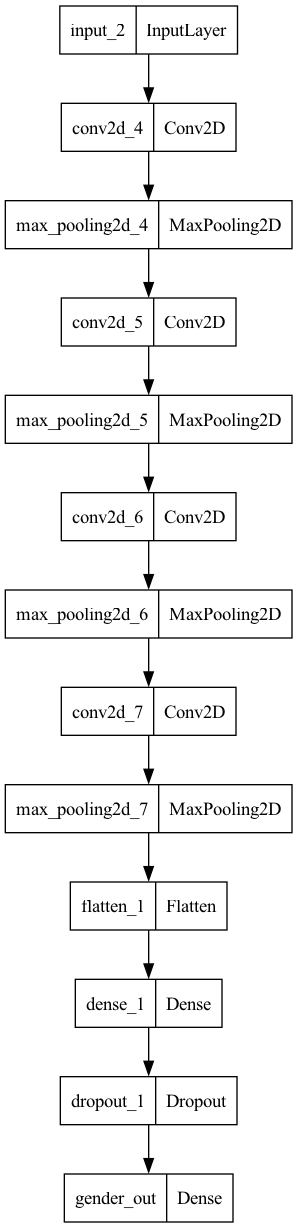

In [35]:
# plot the model
plot_model(model)


In [36]:
# Training the Neural Network Model
history = model.fit(
    x=X,  # Input data (preprocessed images)
    y=y_gender,  # Target output (gender labels)
    batch_size=32,  # Number of samples per update
    epochs=10,  # Number of training epochs (iterations over the dataset)
    validation_split=0.2  # Percentage of training data used for validation
)


Epoch 1/10
593/593 [==============================] - 123s 207ms/step - loss: 0.4654 - accuracy: 0.4750 - val_loss: 0.3452 - val_accuracy: 0.4867
Epoch 2/10
593/593 [==============================] - 117s 198ms/step - loss: 0.3204 - accuracy: 0.4750 - val_loss: 0.3164 - val_accuracy: 0.4867
Epoch 3/10
593/593 [==============================] - 118s 198ms/step - loss: 0.2745 - accuracy: 0.4750 - val_loss: 0.2786 - val_accuracy: 0.4867
Epoch 4/10
593/593 [==============================] - 118s 199ms/step - loss: 0.2476 - accuracy: 0.4750 - val_loss: 0.2898 - val_accuracy: 0.4867
Epoch 5/10
593/593 [==============================] - 118s 200ms/step - loss: 0.2282 - accuracy: 0.4750 - val_loss: 0.2776 - val_accuracy: 0.4867
Epoch 6/10
593/593 [==============================] - 119s 200ms/step - loss: 0.2073 - accuracy: 0.4750 - val_loss: 0.2796 - val_accuracy: 0.4867
Epoch 7/10
593/593 [==============================] - 119s 201ms/step - loss: 0.1866 - accuracy: 0.4750 - val_loss: 0.3227 -

## Plot Results

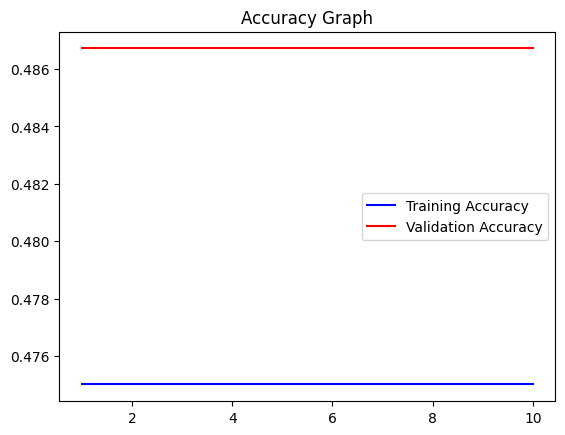

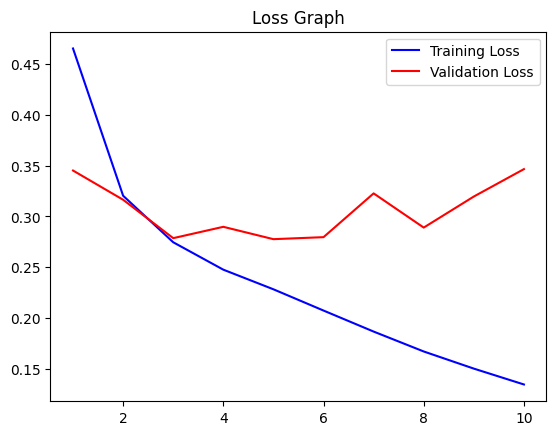

In [37]:
# Plotting the Training and Validation Accuracy
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy
epochs = range(1, len(acc) + 1)  # Number of epochs

plt.plot(epochs, acc, 'b', label='Training Accuracy')  # Plotting training accuracy
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')  # Plotting validation accuracy
plt.title('Accuracy Graph')  # Title of the graph
plt.legend()  # Show legend for clarity
plt.figure()  # Create a new figure for the next plot

# Plotting the Training and Validation Loss
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

plt.plot(epochs, loss, 'b', label='Training Loss')  # Plotting training loss
plt.plot(epochs, val_loss, 'r', label='Validation Loss')  # Plotting validation loss
plt.title('Loss Graph')  # Title of the graph
plt.legend()  # Show legend for clarity
plt.show()  # Display the plots


## Train the VGG16 model


In [41]:
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


58889256/58889256 [==============================] - 7s 0us/step


In [2]:
X_rgb = np.repeat(X[..., np.newaxis], 3, -1)


NameError: name 'np' is not defined

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

# Assuming X contains your grayscale images (shape: (num_samples, height, width, 1))
# Convert grayscale images to RGB
X_rgb = np.repeat(X, 3, axis=-1)

# Resize images to VGG16 input shape (224x224)
X_resized = []
for img in X_rgb:
    img = cv2.resize(img, (224, 224))
    X_resized.append(img)
X_resized = np.array(X_resized)

# Preprocess input according to VGG16 requirements
X_processed = preprocess_input(X_resized)

# Train the VGG16 model with this preprocessed data
history = vgg16_model.fit(X_processed, y_gender, epochs=10, batch_size=32, validation_data=(X, y_gender))


: 

## Predicting Test Data

In [38]:
# Instantiate detectors
gender_detector =  f_my_gender.Gender_Model()  # Initialize gender detection model
emotion_detector = f_emotion_detection.predict_emotions()  # Initialize emotion detection model

def get_face_info(im):
    # Face detection
    boxes_face = face_recognition.face_locations(im)
    out = []  # Initialize an empty list to store face information
    if len(boxes_face) != 0:
        for box_face in boxes_face:
            # Segment face coordinates
            box_face_fc = box_face
            x0, y1, x1, y0 = box_face
            box_face = np.array([y0, x0, y1, x1])
            face_features = {
                "gender": [],
                "emotion": [],
                "bbx_frontal_face": box_face
            } 

            face_image = im[x0:x1, y0:y1]  # Crop face from the image

            # Gender detection
            face_features["gender"] = gender_detector.predict_gender(face_image)

            # Emotion detection
            _, emotion = emotion_detector.get_emotion(im, [box_face])
            face_features["emotion"] = emotion[0]

            out.append(face_features)  # Store face features in the list
    else:
        face_features = {
            "gender": [],
            "emotion": [],
            "bbx_frontal_face": []             
        }
        out.append(face_features)  # Store empty face information

    return out

def bounding_box(out, img):
    faces_detected = False  # Flag to check if faces are detected
    
    # Iterate through each detected face
    for data_face in out:
        box = data_face["bbx_frontal_face"]  # Get face coordinates
        if len(box) == 0:  # If no face detected, continue to the next iteration
            continue
        else:
            x0, y0, x1, y1 = box  # Extract face coordinates
            faces_detected = True  # Set flag to indicate face detection
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)  # Draw rectangle around face
            thickness = 2
            fontSize = 0.5
            step = 20

            gender = data_face["gender"]  # Get predicted gender
            emotion = data_face["emotion"]  # Get predicted emotion

            if gender != "No face detected":
                try:
                    cv2.putText(img, "Gender: " + gender, (x0, y0 - step - 10 * 1), cv2.FONT_HERSHEY_SIMPLEX, fontSize, (205, 38, 38), thickness)  # Add gender label
                except:
                    pass

            if emotion != "No face detected":
                try:
                    cv2.putText(img, "Emotion: " + emotion, (x0, y0 - step - 17 * 3), cv2.FONT_HERSHEY_SIMPLEX, fontSize, (255, 225, 225), thickness)  # Add emotion label
                except:
                    pass

    if not faces_detected:  # If no faces detected
        print("No faces detected in the image.")
    else:
        print("Detected Faces Information:")
        for data_face in out:  # Iterate through detected faces
            box = data_face["bbx_frontal_face"]  # Get face coordinates
            if len(box) == 0:  # If no face detected, continue to the next iteration
                continue
            else:
                gender = data_face["gender"]  # Get predicted gender
                emotion = data_face["emotion"]  # Get predicted emotion

                print("Face Info:")
                print(f" - Gender: {gender}")  # Print gender information
                print(f" - Emotion: {emotion}")  # Print emotion information
                print("-------------------")

    return img  # Return image with bounding boxes and labels


## running over an image



In [39]:
!python3 Face_info.py --input image --path_im /Users/khalifa/Desktop/Face_info-master/data_test/istockphoto-1330569516-612x612.jpg


1/1 [==============================] - 0s 16ms/step
Detected Faces Information:
Face Info:
 - Gender: Woman
 - Emotion: happy
-------------------
Face Info:
 - Gender: Woman
 - Emotion: happy
-------------------
Face Info:
 - Gender: Woman
 - Emotion: happy
-------------------
Face Info:
 - Gender: Woman
 - Emotion: happy
-------------------
Face Info:
 - Gender: Man
 - Emotion: happy
-------------------
Face Info:
 - Gender: Woman
 - Emotion: happy
-------------------
^C


## running over an webcam


In [ ]:
!python3 Face_info.py --input webcam 


No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
No faces detected in the image.
1/1 [==============================] - 0s 93ms/step
Detected Faces Information:
Face Info:
 - Gender: Man
 - Emotion: neutral
-------------------
No faces detected in the image.
1/1 [=================